# Minimal Model

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [17]:
# Model design
import agentpy as ap
import networkx as nx 
import random 
import numpy as np

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

np.random.seed(42)

## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Defining the model

We define a new agent type :class:`Person` by creating a subclass of :class:`Agent`.
This agent has two methods: :func:`setup` will be called automatically at the agent's creation,
and :func:`being_sick` will be called by the :func:`Model.step` function.
Three tools are used within this class:

- :attr:`Agent.p` returns the parameters of the model
- :func:`Agent.neighbors` returns a list of the agents' peers in the network
- :func:`random.random` returns a uniform random draw between 0 and 1

wealth by race https://www.federalreserve.gov/econres/notes/feds-notes/disparities-in-wealth-by-race-and-ethnicity-in-the-2019-survey-of-consumer-finances-20200928.html

rank for the US:
https://www.federalreserve.gov/econres/notes/feds-notes/wealth-inequality-and-the-racial-wealth-gap-accessible-20211022.htm#fig3


In [5]:
# import matplotlib.pyplot as plt

# values = plt.hist(np.random.beta(1.5, 5, 10000),

#                   bins=200, density=True)

# # plt.show()

In [6]:
# import matplotlib.pyplot as plt

# values = plt.hist(np.random.beta(5, 3, 10000),

#                   bins=200, density=True)

# plt.show()

In [223]:
class Person(ap.Agent):
    
    def setup(self):  
        """ Initialize a new variable at agent creation. """
        # self.condition = 0  # Susceptible = 0, Infected = 1, Recovered = 2
        a = 5 # shape
        rng = np.random.default_rng()
        
        
        # race
        self.race =  rng.binomial(1,0.2)#binary not white0.2 /  white for the moment 0.8
        
        if self.race == 0:
            self.wealth = rng.beta(1.5, 5,1)[0]
        else:
            self.wealth = rng.beta(5, 3,1)[0]
            

        # fraud
        self.fraud = rng.binomial(1,0.5,1)[0]
        self.fraud_pred = -1
        self.convicted = 0

        
        
        
    def fraud_algo(self):
        """ DM mechanism can also be ML"""
        rng = np.random.default_rng()
        # self.fraud_pred = rng.binomial(1, 0.5)
        if self.fraud == 1:
            fraud_cor = rng.binomial(1,self.p.acc)
        else:
            fraud_cor = rng.binomial(1,1-self.p.acc)
            
        self.fraud_pred = rng.binomial(1, fraud_cor*(0.8-self.p.wealth_appeal_corr))
        

            
    def convict(self):
        """ Conviction and Consequences"""
        rng = np.random.default_rng()
        if self.fraud_pred == 1:
            if rng.binomial(1,self.p.conviction_rate) == 1:
                # pay fine, get on record, 
                self.wealth = self.wealth - np.max([0.01,(pow(self.wealth,2)*0.1)])
                self.convicted =+ 1
                self.fraud = rng.binomial(1,0.5,1)[0]
                self.fraud_pred = 0
            
            
    def convict_true(self):
        """ Conviction and Consequences"""
        rng = np.random.default_rng()
        if self.fraud == 1:
            if rng.binomial(1,self.p.conviction_rate) == 1:
                # pay fine, get on record, 
                self.wealth = self.wealth - (0.1)#(self.wealth*0.05)])
                self.convicted =+ 1
                self.fraud = rng.binomial(1,0.5,1)[0]
                self.fraud_pred = 0

    def wealth_grow(self):
        self.wealth = min(1,self.wealth+pow(self.wealth,2)*0.1)
        
            


Next, we define our model :class:`VirusModel` by creating a subclass of :class:`Model`.
The four methods of this class will be called automatically at different steps of the simulation,
as described in :ref:`overview_simulation`.

In [196]:
class VirusModel(ap.Model):
    
    def setup(self): #before
        """ Initialize the agents and network of the model. """

#         # Create agents and network
        self.agents = ap.AgentList(self, self.p.agents, Person)
    
        self.w_wealth_t0 = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        self.nw_wealth_t0 = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
    

    def step(self): # during each step
        """ Define the models' events per simulation step. """
        self.agents.fraud_algo()
#         self.agents.appeal()
        self.agents.convict()
        self.agents.wealth_grow()
        



    def update(self):  # after each step
        """ Record variables after setup and each step. """
        self.agents.record('wealth')
        self.agents.record('fraud_pred')
        self.agents.record('fraud')
        self.agents.record('race')
        
        
    
    
    def end(self):     
        """ Record evaluation measures at the end of the simulation. """
#         self.report('wealth', self.agents.wealth)
#         self.report('race', self.agents.race)
#         self.report('my_measure', 1)
        
        # record race wealth ratio 
        
        w_wealth_tn = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        nw_wealth_tn = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
        
        w_wr_ratio = w_wealth_tn/self.w_wealth_t0
        nw_wr_ratio = nw_wealth_tn/self.nw_wealth_t0
        
        # general wealth 
        wealth = sum((self.agents).wealth) / len((self.agents))
        
        self.report('w_wr_ratio', w_wr_ratio)
        self.report('nw_wr_ratio', nw_wr_ratio)
        self.report('wealth', wealth)
            
        

In [224]:
class VirusModel_mvp(ap.Model):
    
    def setup(self): #before
        """ Initialize the agents and network of the model. """

#         # Create agents and network
        self.agents = ap.AgentList(self, self.p.agents, Person)
    
        self.w_wealth_t0 = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        self.nw_wealth_t0 = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
    

    def step(self): # during each step
        """ Define the models' events per simulation step. """
#         self.agents.fraud_algo()
#         self.agents.appeal()
        self.agents.convict_true()
        self.agents.wealth_grow()
        



    def update(self):  # after each step
        """ Record variables after setup and each step. """
        self.agents.record('wealth')
        self.agents.record('fraud_pred')
        self.agents.record('fraud')
        self.agents.record('race')
        
        
    
    def end(self):     
        """ Record evaluation measures at the end of the simulation. """
#         self.report('wealth', self.agents.wealth)
#         self.report('race', self.agents.race)
#         self.report('my_measure', 1)
        
        # record race wealth ratio 
        
        w_wealth_tn = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        nw_wealth_tn = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
        
        w_wr_ratio = w_wealth_tn/self.w_wealth_t0
        nw_wr_ratio = nw_wealth_tn/self.nw_wealth_t0
        
        # general wealth 
        wealth = sum((self.agents).wealth) / len((self.agents))
        
        self.report('w_wr_ratio', w_wr_ratio)
        self.report('nw_wr_ratio', nw_wr_ratio)
        self.report('wealth', wealth)
            
            
        

## Running a simulation

To run our model, we define a dictionary with our parameters. 
We then create a new instance of our model, passing the parameters as an argument, 
and use the method :func:`Model.run` to perform the simulation and return it's output. 

Completed: 50 steps
Run time: 0:00:01.632577
Simulation finished


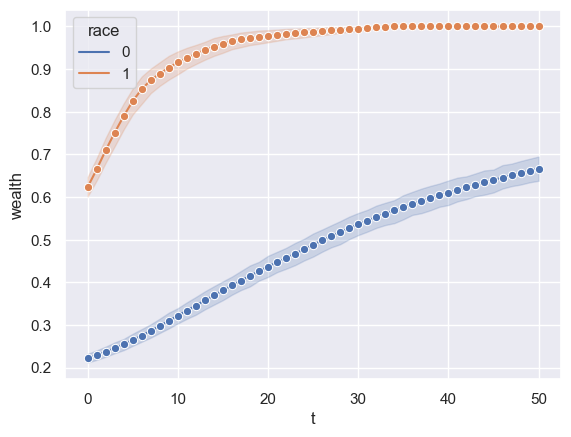

In [229]:
parameters = {
    'my_parameter':42,
    'agents':1000,
    'steps':50,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'conviction_rate': 0,
    'appeal_wealth': 0.2 # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    
}

model = VirusModel(parameters)
results = model.run() 

df = results['variables']['Person']
fig, ax = plt.subplots()

sns.lineplot(ax = ax,
             data = df,
             x = df.index.get_level_values('t'),
             y = df['wealth'].astype(float),
             hue = df['race'],
             marker = 'o')

plt.show()

Completed: 50 steps
Run time: 0:00:00.929288
Simulation finished


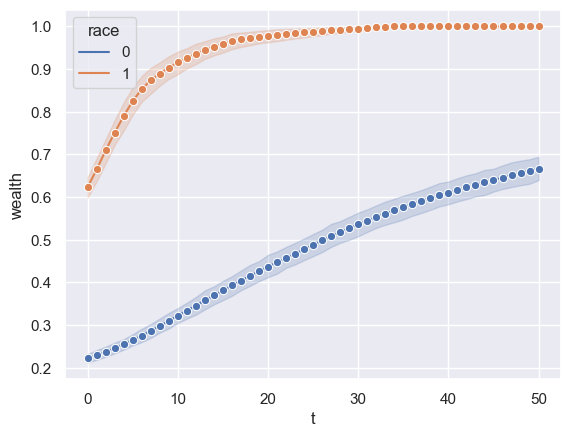

In [230]:
model = VirusModel_mvp(parameters)
results_mvp = model.run() 

df = results['variables']['Person']
fig, ax = plt.subplots()

sns.lineplot(ax = ax,
             data = df,
             x = df.index.get_level_values('t'),
             y = df['wealth'].astype(float),
             hue = df['race'],
             marker = 'o')

plt.show()

## Analyzing results

The simulation returns a :class:`DataDict` of recorded data with dataframes:

In [152]:
r =results['variables']['Person']
rmvp = results_mvp['variables']['Person']
x = r.index.get_level_values('t')
y = r['wealth'].astype(float)
hue = r['race']
xmvp = rmvp.index.get_level_values('t')
ymvp = rmvp['wealth'].astype(float)
huemvp = rmvp['race']

In [67]:
dy = ymvp - y


In [128]:
rw_mvp = rmvp[['wealth','race']]
rw_mvp

wealth  race
obj_id t                  
1      0    0.665395     1
       1    0.659690     1
       2    0.664042     1
       3    0.668452     1
       4    0.672920     1
...              ...   ...
1000   96   0.061730     0
       97   0.061768     0
       98   0.061807     0
       99   0.061845     0
       100  0.061883     0

[101000 rows x 2 columns]

In [153]:
rw_mvp0 = (rmvp.loc[rmvp['race'] == 0]['wealth']).groupby('t').mean()
rw_mvp1 = (rmvp.loc[rmvp['race'] == 1]['wealth']).groupby('t').mean()

rw_mvp0-rw_mvp1

t
0    -0.400883
1    -0.404566
2    -0.408481
3    -0.412254
4    -0.416011
5    -0.419751
6    -0.423576
7    -0.427347
8    -0.431122
9    -0.434889
10   -0.438676
11   -0.442524
12   -0.446435
13   -0.450366
14   -0.454343
15   -0.458316
16   -0.462211
17   -0.466064
18   -0.469849
19   -0.473608
20   -0.477387
21   -0.481129
22   -0.484928
23   -0.488731
24   -0.492547
25   -0.496303
26   -0.499943
27   -0.503480
28   -0.506940
29   -0.510383
30   -0.513700
31   -0.517051
32   -0.520382
33   -0.523635
34   -0.526810
35   -0.529857
36   -0.532873
37   -0.535763
38   -0.538420
39   -0.540962
40   -0.543448
41   -0.545959
42   -0.548485
43   -0.550898
44   -0.553139
45   -0.555399
46   -0.557602
47   -0.559712
48   -0.561790
49   -0.563794
50   -0.565701
Name: wealth, dtype: float64

In [143]:
r0 = (r.loc[r['race'] == 0]['wealth']).groupby('t').mean()
r1 = (r.loc[r['race'] == 1]['wealth']).groupby('t').mean()

r0-r1

t
0    -0.389335
1    -0.392723
2    -0.396479
3    -0.399630
4    -0.402853
5    -0.406267
6    -0.409948
7    -0.414139
8    -0.417285
9    -0.421699
10   -0.425424
11   -0.429198
12   -0.433089
13   -0.436801
14   -0.440317
15   -0.444435
16   -0.448045
17   -0.451752
18   -0.455061
19   -0.458214
20   -0.461888
21   -0.464961
22   -0.468118
23   -0.471775
24   -0.475490
25   -0.479554
26   -0.483567
27   -0.487634
28   -0.491166
29   -0.495251
30   -0.499101
31   -0.503279
32   -0.506914
33   -0.510395
34   -0.513226
35   -0.516376
36   -0.519521
37   -0.523537
38   -0.527227
39   -0.531086
40   -0.534721
41   -0.538211
42   -0.541542
43   -0.545121
44   -0.548412
45   -0.551830
46   -0.555359
47   -0.558998
48   -0.562607
49   -0.565707
50   -0.568618
Name: wealth, dtype: float64

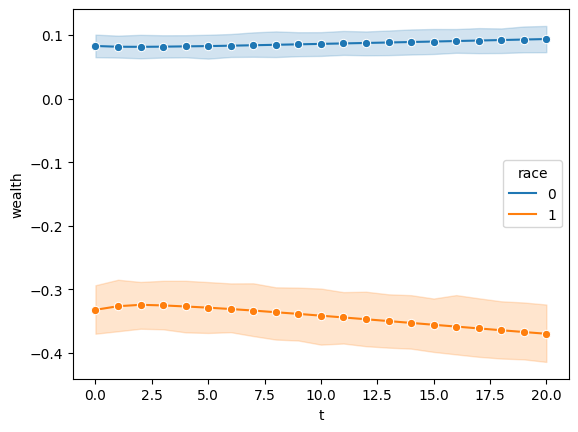

In [69]:
fig, ax = plt.subplots()
df = results['variables']['Person']
sns.lineplot(ax = ax,
             data = df,
             x = r.index.get_level_values('t'),
             y = dy,
             hue = hue,
             marker = 'o')

plt.show()

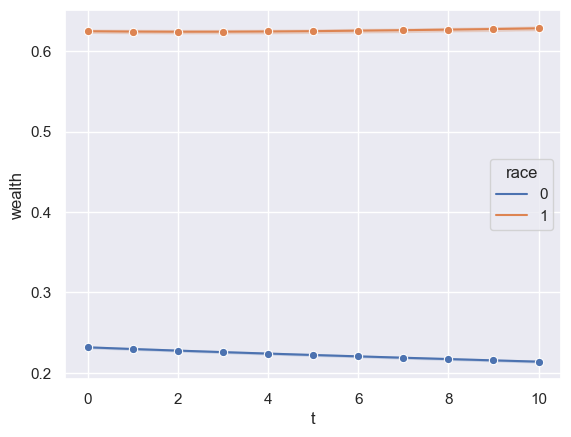

In [194]:
df = results['variables']['Person']
fig, ax = plt.subplots()

sns.lineplot(ax = ax,
             data = df,
             x = df.index.get_level_values('t'),
             y = df['wealth'].astype(float),
             hue = df['race'],
             marker = 'o')

plt.show()

To visualize the evolution of our variables over time, we create a plot function.

In [7]:
# def virus_stackplot(data, ax):
#     """ Stackplot of people's condition over time. """
#     x = data.index.get_level_values('t')
#     y = [data[var] for var in ['I', 'S', 'R']]
    
#     sns.set()
#     ax.stackplot(x, y, labels=['Infected', 'Susceptible', 'Recovered'],
#                  colors = ['r', 'b', 'g'])    
    
#     ax.legend()
#     ax.set_xlim(0, max(1, len(x)-1))
#     ax.set_ylim(0, 1)
#     ax.set_xlabel("Time steps")
#     ax.set_ylabel("Percentage of population")

# fig, ax = plt.subplots()
# virus_stackplot(results.variables.VirusModel, ax)

## Creating an animation

We can also animate the model's dynamics as follows.
The function :func:`animation_plot` takes a model instance 
and displays the previous stackplot together with a network graph. 
The function :func:`animate` will call this plot
function for every time-step and return an :class:`matplotlib.animation.Animation`.

In [8]:
# def animation_plot(m, axs):
#     ax1, ax2 = axs
#     ax1.set_title("Virus spread")
#     ax2.set_title(f"Share infected: {m.I}")
    
#     # Plot stackplot on first axis
#     virus_stackplot(m.output.variables.VirusModel, ax1)
    
#     # Plot network on second axis
#     color_dict = {0:'b', 1:'r', 2:'g'}
#     colors = [color_dict[c] for c in m.agents.condition]
#     nx.draw_circular(m.network.graph, node_color=colors, 
#                      node_size=50, ax=ax2)

# fig, axs = plt.subplots(1, 2, figsize=(8, 4)) # Prepare figure 
# parameters['population'] = 50 # Lower population for better visibility 
# animation = ap.animate(VirusModel(parameters), fig, axs, animation_plot)

Using Jupyter, we can display this animation directly in our notebook.

In [9]:
# IPython.display.HTML(animation.to_jshtml()) 

## Multi-run experiment

To explore the effect of different parameter values, 
we use the classes :class:`Sample`, :class:`Range`, and :class:`IntRange`
to create a sample of different parameter combinations.

What I want is trying a bunch of 

In [231]:
# parameters = {
#     'population': ap.IntRange(100, 1000),
#     'infection_chance': ap.Range(0.1, 1.),
#     'recovery_chance': ap.Range(0.1, 1.),
#     'initial_infection_share': 0.1,
#     'number_of_neighbors': 2,
#     'network_randomness': ap.Range(0., 1.)
# }
# parameters = {  
#     'population': 1000,
#     'infection_chance': 0.3,
#     'recovery_chance': 0.1,
#     'initial_infection_share': 0.1,
#     'number_of_neighbors': 2,
#     'network_randomness': 0.5   
# }

parameters = {
    'my_parameter':42,
    'agents':ap.IntRange(50, 150),
    'steps':50,
    'wealth_appeal_corr': 0, #ap.Range(-0.2, 0.2), # >0 more wealth higher appeal chance
    'acc': 0.8, #ap.Range(0.5, 0.8), # accuracy of fraud prdediction
    'conviction_rate': ap.Range(0,1),
    'appeal_wealth': 0.2 # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
} 

sample = ap.Sample(
    parameters, 
    n=128, 
    method='saltelli', 
    calc_second_order=False
)

We then create an :class:`Experiment` that takes a model and sample as input.
:func:`Experiment.run` runs our model repeatedly over the whole sample 
with ten random iterations per parameter combination.

In [232]:
exp = ap.Experiment(VirusModel_mvp, sample, iterations=2, record = True)
results = exp.run()

Scheduled runs: 1024
Completed: 1024, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:01:33.596569


Optionally, we can save and load our results as follows:

In [184]:
results.save()

Data saved to ap_output/VirusModel_9


In [185]:
results = ap.DataDict.load('VirusModel')

Loading from directory ap_output/VirusModel_9/
Loading parameters_sample.csv - Successful
Loading parameters_constants.json - Successful
Loading reporters.csv - Successful
Loading info.json - Successful
Loading variables_Person.csv - Successful
Loading parameters_log.json - Successful


In [186]:
results['reporters']

seed  w_wr_ratio  \
sample_id iteration                                                        
0         0          279701951157731131776818514243429580832    1.011930   
          1          171092131886094625643394338857781442875    0.979167   
1         0           92898589260260698211806605491694735533    0.996297   
          1          162901249188527534808479688430543268298    0.989773   
2         0          227758326022822350402721323646709856248    0.988867   
...                                                      ...         ...   
637       1          179982798314234473818153331780059336077    1.021396   
638       0          316181043737617747370667931192623098580    1.008296   
          1          175926058543354181336672819878565108039    1.040949   
639       0           77062607861786758937148829945058809883    1.004392   
          1          183207415633593973495198180693833229024    1.005576   

                     nw_wr_ratio  
sample_id iteration               
0         0             0.869604  
          1             0.923570  
1         0             0.911715  
          1             0.916680  
2         0             0.942885  
...                          ...  
637       1             0.906122  
638       0             0.970563  
          1             0.946538  
639       0             0.951968  
          1             0.930312  

[1280 rows x 3 columns]

The measures in our :class:`DataDict` now hold one row for each simulation run.

In [58]:
a =results['parameters']['sample']
a

,agents,wealth_appeal_corr,acc
sample_id,,,
0,51,-0.067187,0.587891
1,69,-0.067187,0.587891
2,51,0.160938,0.587891
3,51,-0.067187,0.702734
4,69,0.160938,0.702734
...,...,...,...
635,50,0.198437,0.730859
636,107,0.198437,0.730859
637,50,0.045312,0.730859


In [167]:
results['reporters']

seed  w_wr_ratio  \
sample_id iteration                                                        
0         0          321035696569074393900800902729492961571    0.990047   
          1          287260272559001834646021956964071460488    1.022115   
1         0          217728001674644233900148970347932507640    0.982531   
          1           37743317432212200141540563100539870987    1.004077   
2         0          123727295008927407268207327782623180901    1.014940   
...                                                      ...         ...   
637       1          105240026411909621910299714156140543514    1.001287   
638       0          164807450361973095883026908734308608851    1.071140   
          1          143165048279318602524160049038863207148    1.059282   
639       0          280528377157528057720635703567106563008    1.018483   
          1           67786655756373883321028286078396635156    1.011888   

                     nw_wr_ratio  
sample_id iteration               
0         0             0.919253  
          1             0.911062  
1         0             0.882188  
          1             0.875650  
2         0             0.964604  
...                          ...  
637       1             0.908712  
638       0             0.968312  
          1             0.964643  
639       0             0.963014  
          1             0.936192  

[1280 rows x 3 columns]

We can use standard functions of the pandas library like 
:func:`pandas.DataFrame.hist` to look at summary statistics.

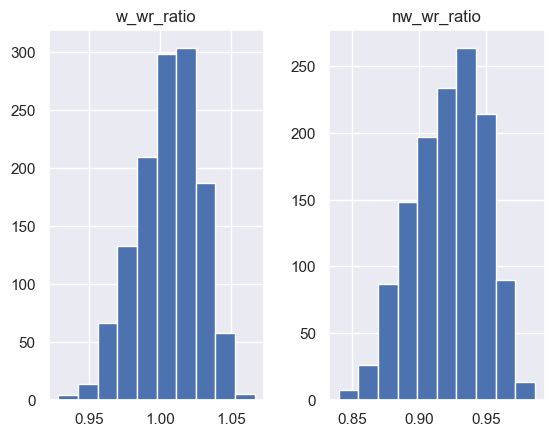

In [187]:
results.reporters.hist();

## Sensitivity analysis

The function :func:`DataDict.calc_sobol` calculates `Sobol sensitivity
indices <https://salib.readthedocs.io/en/latest/api.html#sobol-sensitivity-analysis>`_ 
for the passed results and parameter ranges, using the 
`SAlib <https://salib.readthedocs.io/en/latest/basics.html>`_ package. 

In [162]:
results.calc_sobol()

/Users/uni/miniconda3/envs/ma/lib/python3.10/site-packages/agentpy/datadict.py:148: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  reporters_df = self.reporters.groupby('sample_id').mean()


DataDict {
'info': Dictionary with 12 keys
'parameters': 
    'constants': Dictionary with 5 keys
    'sample': DataFrame with 2 variables and 512 rows
    'log': Dictionary with 5 keys
'variables': 
    'Person': DataFrame with 4 variables and 1126400 rows
'reporters': DataFrame with 3 variables and 1024 rows
'sensitivity': 
    'sobol': DataFrame with 2 variables and 4 rows
    'sobol_conf': DataFrame with 2 variables and 4 rows
}

In [184]:
results['reporters']

seed  w_wr_ratio  \
sample_id iteration                                                        
0         0          201127979187335725271791035746997099285    1.019027   
          1          323839674617043970730054114000226751147    1.015267   
1         0          110513033417182203854599292662408207467    1.024606   
          1           27214224125703884466114982640814134766    1.028231   
2         0           21265541589308886014445432220696059325    1.005736   
...                                                      ...         ...   
509       1          102218631291135076433582405430875501552    1.016878   
510       0           36214964857578104884456857028549855447    1.036711   
          1          113386646292148884636443058557192566592    1.007625   
511       0          311370917880915171616748428855937439912    1.020409   
          1          158030614946259441261075930300714991771    1.018663   

                     nw_wr_ratio    wealth  
sample_id iteration                         
0         0             0.927258  0.319851  
          1             0.895538  0.215841  
1         0             0.902662  0.340275  
          1             0.880421  0.285859  
2         0             0.910559  0.312651  
...                          ...       ...  
509       1             0.893652  0.307179  
510       0             0.873279  0.233348  
          1             0.888891  0.309217  
511       0             0.924633  0.286675  
          1             0.893401  0.298566  

[1024 rows x 4 columns]

In [164]:
si_list = results.sensitivity.sobol.groupby(by='reporter')
si_conf_list = results.sensitivity.sobol_conf.groupby(by='reporter')
results.sensitivity.sobol

S1        ST
reporter    parameter                          
w_wr_ratio  agents          -0.359288  1.114783
            conviction_rate  0.098686  1.021505
nw_wr_ratio agents          -0.180902  0.996466
            conviction_rate -0.314714  1.020276

This adds a new category `sensitivity` to our results, which includes:

- :attr:`sobol` returns first-order sobol sensitivity indices
- :attr:`sobol_conf` returns confidence ranges for the above indices

We can use pandas to create a bar plot that visualizes these sensitivity indices.

                                   S1        ST
reporter    parameter                          
nw_wr_ratio agents          -0.180902  0.996466
            conviction_rate -0.314714  1.020276
                       S1        ST
parameter                          
agents          -0.180902  0.996466
conviction_rate -0.314714  1.020276
                                  S1        ST
reporter   parameter                          
w_wr_ratio agents          -0.359288  1.114783
           conviction_rate  0.098686  1.021505
                       S1        ST
parameter                          
agents          -0.359288  1.114783
conviction_rate  0.098686  1.021505


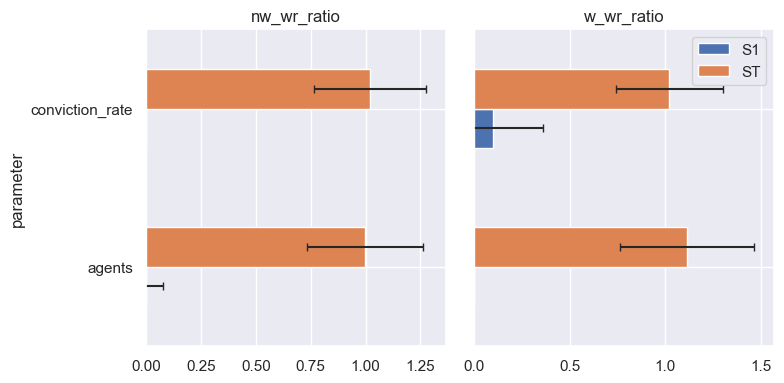

In [165]:
def plot_sobol(results):
    """ Bar plot of Sobol sensitivity indices. """
    
    sns.set()
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    si_list = results.sensitivity.sobol.groupby(by='reporter')
    si_conf_list = results.sensitivity.sobol_conf.groupby(by='reporter')

    for (key, si), (_, err), ax in zip(si_list, si_conf_list, axs):
        print(si)
        si = si.droplevel('reporter')
        print(si)
        err = err.droplevel('reporter')
        si.plot.barh(xerr=err, title=key, ax=ax, capsize = 3)
        ax.set_xlim(0)
    
    axs[0].get_legend().remove()
    axs[1].set(ylabel=None, yticklabels=[]) 
    axs[1].tick_params(left=False)
    plt.tight_layout()
    
plot_sobol(results)

Alternatively, we can also display sensitivities by plotting 
average evaluation measures over our parameter variations. 

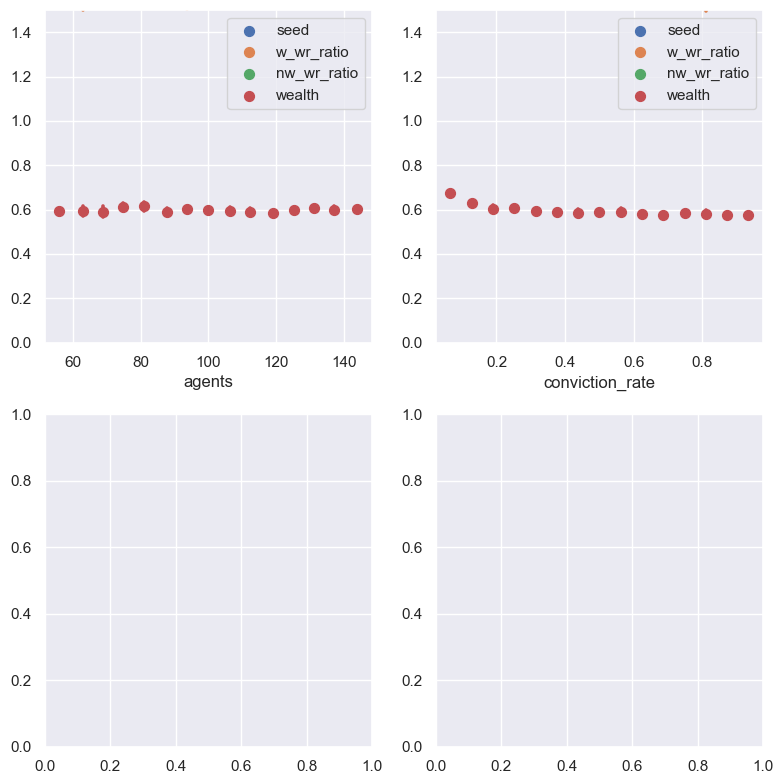

In [233]:
def plot_sensitivity(results):
    """ Show average simulation results for different parameter values. """
    
    sns.set()
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = [i for j in axs for i in j] # Flatten list
    
    data = results.arrange_reporters().astype('float')
    params = results.parameters.sample.keys() 
    
    for x, ax in zip(params, axs):
        for y in results.reporters.columns:
            sns.regplot(x=x, y=y, data=data, ax=ax, ci=99, 
                        x_bins=15, fit_reg=False, label=y)  
        ax.set_ylim(0,1.5)
        ax.set_ylabel('')
        ax.legend()
        
    plt.tight_layout()

plot_sensitivity(results)